# ДЗ 1
## Классический МЛ в NLP, вспомнить все!

В этом ДЗ будем работать с датасетом Men_Women_Shoes_Reviews ttps://www.kaggle.com/daishinkan002/men-women-shoes-reviews 
 

### **Задание 1**. 
Предсказать цену по описанию товара (для каждого товара)
### **Задание 2.** 
Предсказать оценку товара пользователем по его отзыву (для каждого отзыва)

## *Что нужно сделать в каждом задании:* 
1) проанализировать данные (все, на что хватит вашей фантазии, хороший анализ включает в себя графики и статистические инструменты анализа, можно приходить с вопросами "какой инструмент поможет мне проверить такую-то гипотезу/хочу посмотреть вот это вот, как это сделать", предварительно не стесняйтесь гуглить) **1 балл**

2) подготовить данные (стемминг, лемматизация, убрать мусор и стоп-слова, нормализовать... все, что покажется вам разумным относительно данных, но вы должны кратко (комментарием к этому блоку кода в тетрадке) объяснить почему вы сделали именно такой препроцессинг. Хороший препроцессинг - разумный, в данном случае чем больше тем не всегда лучше) **1 балла**

3) векторизовать тексты (контекстуальные эммбединги пока что не берем, только BoW и TF-IDF) **0.5 балл**

4) сделать гридсерч по нескольким моделям (у нас 2 задания, классификация и регрессия), подобрать гиперпараметры, выбрать лучшую модель, рассказать, почему, на ваш взгляд,лучший результат показал лучший алгоритм **1 балл**

5) оценить и проанализировать качество лучших решений для каждой задачи (рассказать с чем ваша модель справляется хорошо, а где у нее "слабые места", можно ли как-то улучшить ваши результаты. Хороший анализ сопровождается графиками) **1,5 балла** 

Максимальная сумма баллов при выполнении 5 пунктов в 2 заданиях - 10

В тетрадке с первого занятия много дополнительной информации, которая может вам помочь, но все равно не стесняйтесь приходить с вопросами в чат курса. 

In [446]:
import pandas as pd
import spacy
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

pd.options.mode.chained_assignment = None
nlp = spacy.load('en_core_web_sm')

In [3]:
shoes = pd.read_csv('Shoes_Data.csv')

In [4]:
shoes.columns

Index(['title', 'price', 'rating', 'total_reviews', 'product_description',
       'reviews', 'reviews_rating', 'Shoe Type'],
      dtype='object')

In [5]:
shoes['price'] = shoes['price'].apply(lambda p: float(p.strip('₹')))
shoes['rating'] = shoes['rating'].apply(lambda p: float(p.split()[0]))
shoes['total_reviews'] = shoes['total_reviews'].apply(lambda p: int(p.split()[0]))

## Задание 1

In [416]:
shoes_prices = shoes.loc[:, ['price', 'product_description']]

Строим "ящик с усами" и видим, что данные в датасете распределены неравномерно, есть "выбросы" в сторону высокой цены.

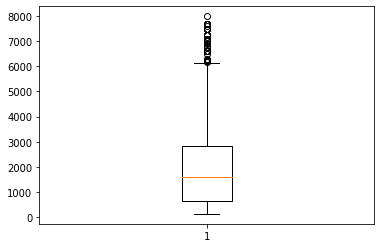

In [417]:
plt.boxplot(shoes_prices['price'])

plt.show()

Здесь я предлагаю несколько корреляций.

In [418]:
print('количество дубликатов:', len(shoes_prices.duplicated()[shoes_prices.duplicated() == True]))
shoes_prices = shoes_prices.drop_duplicates()

количество дубликатов: 261


In [419]:
shoes_prices['length'] = shoes_prices['product_description'].apply(lambda d: len(d))
print('корреляция Пирсона между ценой и длиной описания в знаках:', 
      shoes_prices['price'].corr(shoes_prices['length']))

корреляция Пирсона между ценой и длиной описания в знаках: 0.18190249918743712


Препроцессинг с помощью spacy: лемматизация, понижение регистра, удаление пунктуации, удаление стоп-слов.

In [420]:
shoes_prices['lemmatized'] = shoes_prices['product_description'].apply(lambda d: [str(n.lemma_).lower() for n in nlp(d) 
                                                                                 if n.is_punct is False\
                                                                                 and n.is_stop is False])

In [421]:
shoes_prices['lemmatized_length'] = shoes_prices['lemmatized'].apply(lambda d: len(d))
print('корреляция Пирсона между ценой и длиной описания в словах:', 
      shoes_prices['price'].corr(shoes_prices['lemmatized_length']))
shoes_prices = shoes_prices.loc[shoes_prices['lemmatized_length'] != 0]

корреляция Пирсона между ценой и длиной описания в словах: 0.1872752069111502


In [422]:
shoes_prices['mean_word_length'] = shoes_prices.apply(lambda row: row['length'] / row['lemmatized_length'], axis=1)
print('корреляция Пирсона между ценой и средней длиной одного слова:', 
      shoes_prices['price'].corr(shoes_prices['mean_word_length']))

корреляция Пирсона между ценой и средней длиной одного слова: -0.18785676011590163


Пытаюсь вычленить бренды с помощью NER.

In [423]:
shoes_prices['brands'] = shoes_prices['product_description'].apply(lambda d: [str(n) for n in nlp(d) 
                                                                              if n.ent_type_ == 'ORG'])
shoes_prices['brands'] = shoes_prices['brands'].apply(lambda d: d[0] if len(d) > 0 else '')

In [424]:
shoes_prices['brands'] = shoes_prices['brands'].apply(lambda d: d[0] if len(d) > 0 else '')

In [425]:
c = Counter(shoes_prices['brands'].tolist())
del c['']
shoes_prices['popular_brand'] = shoes_prices['brands'].apply(lambda d: c[d])
print('корреляция Пирсона между ценой и популярностью бренда:',
      shoes_prices['price'].corr(shoes_prices['popular_brand']))

корреляция Пирсона между ценой и популярностью бренда: -0.034387946635689455


In [223]:
shoes_prices['lemmatized'] = shoes_prices['lemmatized'].apply(lambda d: ' '.join(d))

In [303]:
tfidf_vec1 = TfidfVectorizer()
tfidf_vec1.fit(shoes_prices['lemmatized'].tolist())
shoes_prices['tfidf'] = shoes_prices['lemmatized'].apply(lambda d: list(tfidf_vec1.transform([d]).toarray()[0]))

К TF-IDF добавляю ещё среднюю длину описания в словах - это признаки.

In [307]:
for i, s in enumerate(shoes_prices['tfidf'].tolist()):
    s.append(shoes_prices['lemmatized_length'][i])

In [310]:
x_train, x_test, y_train, y_test = train_test_split(shoes_prices['tfidf'].tolist(), shoes_prices['price'].tolist(), test_size=0.2, random_state=42)

ML

In [311]:
lr = LinearRegression()

parameter_grid_lr = {'fit_intercept': [True, False],
                    'positive': [True, False]}

grid_search = GridSearchCV(lr, param_grid=parameter_grid_lr, scoring='neg_root_mean_squared_error')
grid_search.fit(x_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: -1499.7320560000528
Best parameters: {'fit_intercept': False, 'positive': True}


In [318]:
lasso = Lasso()

parameter_grid_lasso = {'fit_intercept': [True, False],
                        'positive': [True, False],
                       'alpha': [0.5, 1, 1.5, 2],
                       'selection': ['random', 'cyclic']}

grid_search = GridSearchCV(lasso, param_grid=parameter_grid_lasso, scoring='neg_root_mean_squared_error')
grid_search.fit(x_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: -1201.394027725888
Best parameters: {'alpha': 1, 'fit_intercept': True, 'positive': False, 'selection': 'cyclic'}


Lasso лучше, так как он лучше работает с разреженными данными, но анализировать работу регрессора не вижу смысла: слишком низкое качество.

## Задание 2

In [328]:
shoes_reviews = shoes.loc[:, ['reviews', 'reviews_rating']]

In [345]:
reviews = []
rates = []
shoes_reviews['reviews'].apply(lambda d: reviews.extend(d.split('||')))
shoes_reviews['reviews_rating'].apply(lambda d: rates.extend([int(float(rate.split()[0])) 
                                                              for rate in d.split('||')]))
shoes_reviews = pd.DataFrame({'reviews': reviews, 'rates': rates})

Посмотрим на распределение по оценкам среди отзывов, написанных капсом.

In [389]:
shoes_reviews['upper_case'] = shoes_reviews['reviews'].apply(lambda l: 1 if l.isupper() else 0)

In [375]:
co = Counter(sorted(shoes_reviews[shoes_reviews['upper_case'] == 1]['rates'].tolist()))

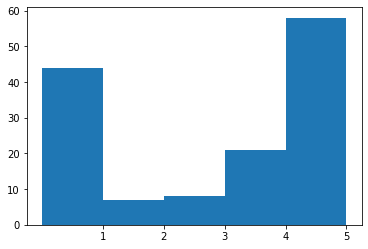

In [376]:
labels, values = zip(*co.items())

indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

Распределение по таргетной переменной (оценка).

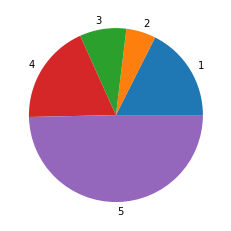

In [383]:
import numpy as np

y = np.array(list(Counter(sorted(shoes_reviews['rates'].tolist())).values()))
mylabels = range(1, 6)

plt.pie(y, labels = mylabels)
plt.show() 

Тот же препроцессинг, но (!) без лемматизации: боюсь потерять слова типа *no*, *not*, да и вообще отзывы достаточно короткие.

In [427]:
shoes_reviews['lemmatized'] = shoes_reviews['reviews'].apply(lambda d: [str(n.lemma_).lower() for n in nlp(d) 
                                                                                 if n.is_punct is False])

In [429]:
shoes_reviews['lemmatized'] = shoes_reviews['lemmatized'].apply(lambda d: ' '.join(d))

In [430]:
shoes_reviews

,reviews,rates,upper_case,emoji,lemmatized
0,Not happy with product,1,0,0,not happy with product
1,It's not as expected.,1,0,0,it be not as expect
2,AVERAGE PRODUCT,3,1,0,average product
3,Pic more beautiful,3,0,0,pic more beautiful
4,Got damage product. But quality is average fo...,3,0,0,got damage product but quality be average fo...
...,...,...,...,...,...
9953,Go for it!,5,0,0,go for it
9954,Excellent product,5,0,0,excellent product
9955,Nice shoe,5,0,0,nice shoe
9956,Nice,5,0,0,nice


In [433]:
shoes_reviews['lemmatized_length'] = shoes_reviews['lemmatized'].apply(lambda d: len(d))
print('корреляция Пирсона между оценкой и длиной описания в словах:', 
      shoes_reviews['rates'].corr(shoes_reviews['lemmatized_length']))
shoes_reviews = shoes_reviews.loc[shoes_reviews['lemmatized_length'] != 0]

корреляция Пирсона между оценкой и длиной описания в словах: -0.14743557226530601


In [437]:
tfidf_vec2 = TfidfVectorizer()
tfidf_vec2.fit(shoes_reviews['lemmatized'].tolist())
shoes_reviews['tfidf'] = shoes_reviews['lemmatized'].apply(lambda d: list(tfidf_vec2.transform([d]).toarray()[0]))

In [438]:
shoes_reviews = shoes_reviews.reset_index()

К TF-IDF добавляю ещё среднюю длину отзыва в словах - это признаки.

In [439]:
for i, s in enumerate(shoes_reviews['tfidf'].tolist()):
    s.append(shoes_reviews['lemmatized_length'][i])

In [441]:
x_train, x_test, y_train, y_test = train_test_split(shoes_reviews['tfidf'].tolist(), 
                                                    shoes_reviews['rates'].tolist(), 
                                                    test_size=0.2, random_state=42)

In [442]:
tree = DecisionTreeClassifier()

parameter_grid_tree = {'criterion':['gini','entropy'],
                        'max_depth':[5, 10, 15, 20, 50, 70, 100, None]}

grid_search = GridSearchCV(tree, param_grid=parameter_grid_tree, scoring='f1_macro')
grid_search.fit(x_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.4769595770526408
Best parameters: {'criterion': 'gini', 'max_depth': None}


In [444]:
tree2 = DecisionTreeClassifier(criterion='gini', max_depth=None)
tree2.fit(x_train, y_train)

DecisionTreeClassifier()

In [448]:
print(classification_report(y_test, tree2.predict(x_test)))

              precision    recall  f1-score   support

           1       0.70      0.71      0.71       341
           2       0.43      0.29      0.35       107
           3       0.44      0.40      0.42       154
           4       0.48      0.31      0.38       356
           5       0.74      0.86      0.79      1034

    accuracy                           0.67      1992
   macro avg       0.56      0.52      0.53      1992
weighted avg       0.65      0.67      0.65      1992



Наиболее низкая оценка у класса, с наименьшим количеством экземпляров. Улучшить можно было бы с помощью ансамблевого метода RandomForrest: он стабильнее.